# Unit Commitment for Colombia's Energy Market
[![unit_commitment_colombia.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/jpbohorquez/uc-colombia/unit_commitment_colombia.ipynb)](https://ampl.com)

Description: Unit Commitment and Reserve Co-Optimization in the Colombian Market.

Tags: amplpy, unit commitment, energy, colombia

Notebook author: Juan Pablo Bohórquez <<juan@ampl.com>>

In [1]:
# Install dependencies
%pip install -q amplpy pandas matplotlib openpyxl

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs", "gurobi", "cplex"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## 1. Problem Description

### Unit Commitment Context

The Unit Commitment (UC) problem is a fundamental challenge in power system operations. Its primary goal is to determine the optimal schedule of electricity generating units to meet the system's demand at the minimum possible cost, while respecting a complex set of operational and physical constraints. These constraints include the generation limits of plants, their ramp-up and ramp-down rates, and minimum up/down times. The UC problem is typically formulated as a Mixed-Integer Linear Program (MILP) due to the binary nature of commitment decisions (a plant is either ON or OFF) and the continuous nature of power generation levels.

### Colombian Energy Market Context

The Colombian wholesale electricity market operates a day-ahead energy market managed by the ISO: XM. In this market, generators submit bids indicating the price at which they are willing to generate electricity. The UC model determines the dispatch schedule for the following day, aiming to satisfy the national demand reliably and economically. The resulting marginal price of the system (uninodal model) is a critical economic signal for all market participants.

### Reserve Co-optimization

In addition to energy, power systems require ancillary services to maintain grid stability. One of the most important services is **operating reserve**, which is standby capacity that can be quickly deployed to handle unexpected events like a generator failure or a sudden surge in demand.

The current Colombian market design often procures reserve for secondary frequency regulation (called Automatic Generation Control - AGC) in a **sequential process**, where the reserve dispatch is determined first and then serves as a fixed input to the energy-only unit commitment model. However, many international markets have transitioned to a **co-optimized** model, where energy and reserve are dispatched simultaneously.

The Colombian energy regulator (CREG) has conducted several studies acknowledging the benefits of this approach. These studies often recommend moving towards a unified model that co-optimizes energy and ancillary services, as it can lead to more economically efficient and reliable system operation.

### Simplifications Made

To create a tractable model, several simplifications were made with respect to how the Colombian market really works:

*   **Bidding Structure:** The model assumes a single bid per plant, whereas real thermal units can have multiple blocks or complex startup/shutdown cost and unit configurations (e.g., warm/cold starts).
*   **Grid Constraints:** The model does not consider transmission network constraints, congestion, or locational prices. This is similar to how the country's energy market really works.
*   **Interconnections:** International energy transactions with neighboring countries are not modeled.
*   **Unique Bid Price:** While the model is written to handle period-differentiated bids, the current data loads a single price for all 24 hours for simplicity and to resemble market's current rules.
*   **Reserve Procurement:** Colombia's market design often optimizes secondary frequency regulation (AGC) separately. This model evaluates a simplified co-optimization where energy and reserve are dispatched simultaneously using distinct bid prices and differentiating upward reserve from downward reserve, allowing for the analysis of alternative market designs.

## 2. Model - MILP

### Mathematical Description of the Problem

The model is formulated as a Mixed-Integer Linear Program (MILP). Below is the mathematical description for the full model including reserve co-optimization. The energy-only model is a subset of this formulation where all reserve-related variables and constraints are removed.

**Sets and Indices:**
- $p \in P$: Set of generaiton plants
- $t \in T$: Set of time periods (hours)

**Decision Variables:**
- $G_{p,t}$: Generation of plant $p$ at time $t$ (MW)
- $u_{p,t}$: Binary variable, 1 if plant $p$ is ON at time $t$, 0 otherwise
- $v_{p,t}$: Binary variable, 1 if plant $p$ starts up at time $t$
- $w_{p,t}$: Binary variable, 1 if plant $p$ shuts down at time $t$
- $D_t$: Unserved energy (deficit) at time $t$ (MW)
- $R_{p,t}^U$: Upward reserve provided by plant $p$ at time $t$ (MW)
- $R_{p,t}^D$: Downward reserve provided by plant $p$ at time $t$ (MW)

**Objective Function:**
The objective is to minimize the total system cost, comprising energy, startup, shutdown, deficit, and reserve procurement costs.
$$
\min \sum_{t \in T} \left( \sum_{p \in P} (C_p^G G_{p,t} + C_p^{SU} v_{p,t} + C_p^{SD} w_{p,t} + C_p^{RU} R_{p,t}^U + C_p^{RD} R_{p,t}^D) + C_t^D D_t \right)
$$
Where:
- $C$: Corresponding cost/bid price parameters for generation, startup, shutdown, reserve, deficit, etc.

**Constraints:**
1.  **Demand and Reserve Balance:**
    $$ \sum_{p \in P} G_{p,t} + D_t = L_t \quad \forall t \in T $$
    $$ \sum_{p \in P} R_{p,t}^U \ge R_t^{U,req} \quad \forall t \in T $$
    $$ \sum_{p \in P} R_{p,t}^D \ge R_t^{D,req} \quad \forall t \in T $$

2.  **Generation & Reserve Limits per Plant:**
    The generation dispatch point must respect the physical limits of the plant, including the headroom and footroom needed for reserve provision.
    $$ G_{p,t} + R_{p,t}^U \le P_{p,t}^{\max} \cdot u_{p,t} \quad \forall p \in P, t \in T $$
    $$ G_{p,t} - R_{p,t}^D \ge P_{p}^{\min} \cdot u_{p,t} \quad \forall p \in P, t \in T $$

3.  **Commitment Logic:**
    $$ u_{p,t} - u_{p,t-1} = v_{p,t} - w_{p,t} \quad \forall p \in P, t \in T $$
    $$ v_{p,t} + w_{p,t} \le 1 \quad \forall p \in P, t \in T $$

4.  **Ramp Rate Constraints:**
    $$ G_{p,t} - G_{p,t-1} \le UR_p \quad \forall p \in P, t \in T $$
    $$ G_{p,t-1} - G_{p,t} \le DR_p \quad \forall p \in P, t \in T $$

5.  **Minimum Up and Down Time Constraints:**
    These constraints ensure that once a unit is turned on (or off), it remains in that state for a minimum duration. This is handled through summation constraints that link startup/shutdown events to the commitment status over a future window.
    $$ \sum_{k=t}^{t+T_{p}^{up}-1} u_{p,k} \ge T_{p}^{up} \cdot v_{p,t} \quad \forall p \in P $$
    $$ \sum_{k=t}^{t+T_{p}^{down}-1} (1 - u_{p,k}) \ge T_{p}^{down} \cdot w_{p,t} \quad \forall p \in P $$
    

### Comments on the `.mod` File

The provided `unit_commitment_reserve.mod` file implements the formulation above, while `unit_commitment.mod` implements the only energy model. Key features include:

- **Robust Constraints:** The minimum up/down time and ramping constraints in the file may differ to those explained above for the sake of simplicity. The modifications seek to correctly handle end-of-horizon effects and initial conditions from `t=0`.
- **Flexibility:** The use of `>=` for the demand balance constraint was found to be faster to solve under certain conditions than a strict equality, while yielding valid results due to the cost minimization objective.
- **Readability:** Parameters and variables follow a consistent naming convention in the `.mod` files, as well as a detailed documentation.
- **Simplicity:** There should be a balance between simplicity of the model and redundancy of some constraints. In the basic implementation, some variables and constraints are defined for all plants, although it may not be necessary. This can lead to unnecessarily bigger models, slower solution times and unexpected variable behaviour. This matter is further discussed in the analysis section.

### Use %%writefile to create the models

In [3]:
%%writefile unit_commitment.mod
# Model Name: Simplified Unit Commitment for Colombia
# Last Updated: 18 July 2025

### SETS
set PLANTS;                     # All the plants connected to the grid
set PERIODS = 1..24;            # Time periods for the model, e.g., hours in a day


### PARAMETERS
param demand {PERIODS} >= 0;                                        # Demand for each period
param max_output {PLANTS, PERIODS} >= 0;                            # Maximum capacity/availability of each plant in each period (MW)
param bid_price {PLANTS, PERIODS} >= 0 default 85;                  # Bid price of each plant in each period ($/kWh). Default value added for price-takers.
param deficit_cost {PERIODS} >= 0;                                  # Cost of unserved energy in each period ($/kWh)
param min_output {PLANTS, PERIODS} >= 0 default 0;                  # Minimum output of each plant if turned on.
param ramp_up {PLANTS} >= 0 default 0;                              # Ramp-up rate of each plant (MW/hour)
param ramp_down {PLANTS} >= 0 default 0;                            # Ramp-down rate of each plant (MW/hour)
param startup_cost {PLANTS} >= 0 default 0;                         # Startup cost of each plant ($)
param shutdown_cost {PLANTS} >= 0 default 0;                        # Shutdown cost of each plant ($)
param min_up_time {PLANTS} integer >= 0 default 0;                  # Minimum number of periods a plant must remain on once started
param min_down_time {PLANTS} integer >= 0 default 0;                # Minimum number of periods a plant must remain off once shut down
param initial_status {PLANTS} binary default 0;                     # Initial status of each plant (1 if on, 0 if off)
param initial_power {PLANTS} >= 0 default 0;                        # Initial power output of each plant (MW)
param initial_hours_on {PLANTS} integer >= 0 default 0;             # Initial hours each plant has been on
param initial_hours_off {PLANTS} integer >= 0 default 0;            # Initial hours each plant has been off


### VARIABLES
var Generation {PLANTS, PERIODS} >= 0;                      # Power generated by each plant in each period (MW)
var BinOn {PLANTS, PERIODS} binary;                         # 1 if plant is on in the period, 0 otherwise
var BinStartUp {PLANTS, PERIODS} binary;                    # 1 if plant starts up in the period, 0 otherwise
var BinShutDown {PLANTS, PERIODS} binary;                   # 1 if plant shuts down in the period, 0 otherwise
var Deficit {PERIODS} >= 0;                                 # Unserved energy in each period (MW)


### OBJECTIVE FUNCTION
minimize TotalCost:  # Measured in thousands of COP
    # Generation costs
    sum {p in PLANTS, t in PERIODS} (bid_price[p,t] * Generation[p,t]) +
    # Startup costs
    sum {p in PLANTS, t in PERIODS} (startup_cost[p] * BinStartUp[p,t]) +
    # Shutdown costs
    sum {p in PLANTS, t in PERIODS} (shutdown_cost[p] * BinShutDown[p,t]) +
    # Penalty for unserved energy
    sum {t in PERIODS} (deficit_cost[t] * Deficit[t]);


### CONSTRAINTS
# Demand Balance
subject to DemandBalance {t in PERIODS}:
    sum {p in PLANTS} Generation[p,t] + Deficit[t] = demand[t];

# Power output limits per plant
subject to PowerOutputLowerLimit {p in PLANTS, t in PERIODS}:
    min_output[p,t] * BinOn[p,t] <= Generation[p,t];

subject to PowerOutputUpperLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] <= max_output[p,t] * BinOn[p,t];

# Binding binaries behaviour
subject to StartUpShutDownLogic {p in PLANTS, t in PERIODS}:
    BinOn[p,t] - (if t = 1 then initial_status[p] else BinOn[p,t-1]) = BinStartUp[p,t]  - BinShutDown[p,t];

subject to NoSimulatneousStartUpShutDown {p in PLANTS, t in PERIODS}:
    BinStartUp[p,t] + BinShutDown[p,t] <= 1;

# Ramp-up and ramp-down constraints
subject to RampUpLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] - (if t = 1 then initial_power[p] else Generation[p,t-1]) <=
    ramp_up[p] * (if t = 1 then initial_status[p] else BinOn[p,t-1]) + max_output[p,t] * BinStartUp[p,t];

subject to RampDownLimit {p in PLANTS, t in PERIODS}:
    (if t = 1 then initial_power[p] else Generation[p,t-1]) - Generation[p,t] <=
    ramp_down[p] * BinOn[p,t] + (if t = 1 then initial_power[p] else max_output[p,t-1]) * BinShutDown[p,t];

# Minimum up time constraint (considering min_up_time greater than 24 hours)
subject to MinimumUpTime {p in PLANTS, t in PERIODS}:
    sum {k in t .. min(t + min_up_time[p] - 1, 24)} BinOn[p,k] >= (min(t + min_up_time[p] - 1, 24) - t + 1) * BinStartUp[p,t];

# Minimum up time constraint (considering initial status)
subject to MinmumUpTimeInitiallyOn {p in PLANTS: initial_status[p] = 1}:
    sum {t in 1 .. max(0,min(min_up_time[p]-initial_hours_on[p], 24))} BinOn[p,t] >= max(0,min(min_up_time[p]-initial_hours_on[p], 24));

# Minimum down time constraint (considering min_down_time greater than 24 hours)
subject to MinimumDownTime {p in PLANTS, t in PERIODS}:
    sum {k in t .. min(t + min_down_time[p] - 1, 24)} (1 - BinOn[p,k]) >= (min(t + min_down_time[p] - 1, 24) - t + 1) * BinShutDown[p,t];

# Minimum down time constraint (considering initial status)
subject to MinimumDownTimeInitiallyOff {p in PLANTS: initial_status[p] = 0}:
    sum {t in 1 .. max(0,min(min_down_time[p]-initial_hours_off[p], 24))} (1 - BinOn[p,t]) >= max(0,min(min_down_time[p]-initial_hours_off[p], 24));


Overwriting unit_commitment.mod


In [4]:
%%writefile unit_commitment_reserve.mod
# Model Name: Simplified Unit Commitment for Colombia, including Reserve
# Last Updated: 18 July 2025

### SETS
set PLANTS;                     # All the plants connected to the grid
set PERIODS = 1..24;            # Time periods for the model, e.g., hours in a day


### PARAMETERS
param demand {PERIODS} >= 0;                                        # Demand for each period
param max_output {PLANTS, PERIODS} >= 0;                            # Maximum capacity/availability of each plant in each period (MW)
param bid_price {PLANTS, PERIODS} >= 0 default 85;                   # Bid price of each plant in each period ($/kWh). Default value added for price-takers.
param deficit_cost {PERIODS} >= 0;                                  # Cost of unserved energy in each period ($/kWh)
param min_output {PLANTS, PERIODS} >= 0 default 0;                  # Minimum output of each plant if turned on.
param ramp_up {PLANTS} >= 0 default 0;                              # Ramp-up rate of each plant (MW/hour)
param ramp_down {PLANTS} >= 0 default 0;                            # Ramp-down rate of each plant (MW/hour)
param startup_cost {PLANTS} >= 0 default 0;                         # Startup cost of each plant ($)
param shutdown_cost {PLANTS} >= 0 default 0;                        # Shutdown cost of each plant ($)
param min_up_time {PLANTS} integer >= 0 default 0;                  # Minimum number of periods a plant must remain on once started
param min_down_time {PLANTS} integer >= 0 default 0;                # Minimum number of periods a plant must remain off once shut down
param initial_status {PLANTS} binary default 0;                     # Initial status of each plant (1 if on, 0 if off)
param initial_power {PLANTS} >= 0 default 0;                        # Initial power output of each plant (MW)
param initial_hours_on {PLANTS} integer >= 0 default 0;             # Initial hours each plant has been on
param initial_hours_off {PLANTS} integer >= 0 default 0;            # Initial hours each plant has been off
param reserve_up_requirement {PERIODS} >= 0 default 0;              # Upward reserve requirement for each period (MW)
param reserve_down_requirement {PERIODS} >= 0 default 0;            # Downward reserve requirement for each period (MW)
param max_reserve_up {PLANTS, PERIODS} >= 0 default 0;              # Maximum upward reserve capacity of each plant in each period (MW)
param max_reserve_down {PLANTS, PERIODS} >= 0 default 0;            # Maximum downward reserve capacity of each plant in each period (MW)
param reserve_up_bid_price {PLANTS, PERIODS} >= 0 default 0;        # Bid price for upward reserve of each plant in each period ($/kWh)
param reserve_down_bid_price {PLANTS, PERIODS} >= 0 default 0;      # Bid price for downward reserve of each plant in each period ($/kWh)


### VARIABLES
var Generation {PLANTS, PERIODS} >= 0;                      # Power generated by each plant in each period (MW)
var BinOn {PLANTS, PERIODS} binary;                         # 1 if plant is on in the period, 0 otherwise
var BinStartUp {PLANTS, PERIODS} binary;                    # 1 if plant starts up in the period, 0 otherwise
var BinShutDown {PLANTS, PERIODS} binary;                   # 1 if plant shuts down in the period, 0 otherwise
var Deficit {PERIODS} >= 0;                                 # Unserved energy in each period (MW)
var ReserveUp {PLANTS, PERIODS} >= 0;                       # Upward reserve provided by each plant in each period (MW)
var ReserveDown {PLANTS, PERIODS} >= 0;                     # Downward reserve provided by each plant in each period (MW)


### OBJECTIVE FUNCTION
minimize TotalCost:  # Measured in thousands of COP
    # Generation costs
    sum {p in PLANTS, t in PERIODS} (bid_price[p,t] * Generation[p,t]) +
    # Startup costs
    sum {p in PLANTS, t in PERIODS} (startup_cost[p] * BinStartUp[p,t]) +
    # Shutdown costs
    sum {p in PLANTS, t in PERIODS} (shutdown_cost[p] * BinShutDown[p,t]) +
    # Penalty for unserved energy
    sum {t in PERIODS} (deficit_cost[t] * Deficit[t]) +
    # Upward reserve costs
    sum {p in PLANTS, t in PERIODS} (reserve_up_bid_price[p,t] * ReserveUp[p,t]) +
    # Downward reserve costs
    sum {p in PLANTS, t in PERIODS} (reserve_down_bid_price[p,t] * ReserveDown[p,t]);


### CONSTRAINTS
# Demand Balance
subject to DemandBalance {t in PERIODS}:
    sum {p in PLANTS} Generation[p,t] + Deficit[t] = demand[t];

# Reserve Balance
subject to ReserveUpBalance {t in PERIODS}:
    sum {p in PLANTS} ReserveUp[p,t] >= reserve_up_requirement[t];

subject to ReserveDownBalance {t in PERIODS}:
    sum {p in PLANTS} ReserveDown[p,t] >= reserve_down_requirement[t];

# Power output limits per plant
subject to PowerOutputLowerLimit {p in PLANTS, t in PERIODS}:
    min_output[p,t] * BinOn[p,t] <= Generation[p,t] - ReserveDown[p,t];

subject to PowerOutputUpperLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] + ReserveUp[p,t] <= max_output[p,t] * BinOn[p,t];

# Reserve limits per plant
subject to ReserveUpLimit {p in PLANTS, t in PERIODS}:
    ReserveUp[p,t] <= max_reserve_up[p,t];

subject to ReserveDownLimit {p in PLANTS, t in PERIODS}:
    ReserveDown[p,t] <= max_reserve_down[p,t];

# Binding binaries behaviour
subject to StartUpShutDownLogic {p in PLANTS, t in PERIODS}:
    BinOn[p,t] - (if t = 1 then initial_status[p] else BinOn[p,t-1]) = BinStartUp[p,t]  - BinShutDown[p,t];

subject to NoSimulatneousStartUpShutDown {p in PLANTS, t in PERIODS}:
    BinStartUp[p,t] + BinShutDown[p,t] <= 1;

# Ramp-up and ramp-down constraints
subject to RampUpLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] - (if t = 1 then initial_power[p] else Generation[p,t-1]) <=
    ramp_up[p] * (if t = 1 then initial_status[p] else BinOn[p,t-1]) + max_output[p,t] * BinStartUp[p,t];

subject to RampDownLimit {p in PLANTS, t in PERIODS}:
    (if t = 1 then initial_power[p] else Generation[p,t-1]) - Generation[p,t] <=
    ramp_down[p] * BinOn[p,t] + (if t = 1 then initial_power[p] else max_output[p,t-1]) * BinShutDown[p,t];

# Minimum up time constraint (considering min_up_time greater than 24 hours)
subject to MinimumUpTime {p in PLANTS, t in PERIODS}:
    sum {k in t .. min(t + min_up_time[p] - 1, 24)} BinOn[p,k] >= (min(t + min_up_time[p] - 1, 24) - t + 1) * BinStartUp[p,t];

# Minimum up time constraint (considering initial status)
subject to MinmumUpTimeInitiallyOn {p in PLANTS: initial_status[p] = 1}:
    sum {t in 1 .. max(0,min(min_up_time[p]-initial_hours_on[p], 24))} BinOn[p,t] >= max(0,min(min_up_time[p]-initial_hours_on[p], 24));

# Minimum down time constraint (considering min_down_time greater than 24 hours)
subject to MinimumDownTime {p in PLANTS, t in PERIODS}:
    sum {k in t .. min(t + min_down_time[p] - 1, 24)} (1 - BinOn[p,k]) >= (min(t + min_down_time[p] - 1, 24) - t + 1) * BinShutDown[p,t];

# Minimum down time constraint (considering initial status)
subject to MinimumDownTimeInitiallyOff {p in PLANTS: initial_status[p] = 0}:
    sum {t in 1 .. max(0,min(min_down_time[p]-initial_hours_off[p], 24))} (1 - BinOn[p,t]) >= max(0,min(min_down_time[p]-initial_hours_off[p], 24));





Overwriting unit_commitment_reserve.mod


## 3. Code Flow

The analysis in this notebook is orchestrated using the `amplpy` library, which provides a seamless interface to the AMPL modeling language and solvers. The following code cells contain the necessary libraries and auxiliary functions (that will be further detailed in the next sections) developed for this project.

**General WorkFlow:**

1.  **Model Instantiation:** An AMPL object is created in Python: `ampl = AMPL()`. This step was covered in a previous cell with the `ampl_notebook()` call to suit colab use.
2.  **Data Loading:** A helper function `add_data_to_ampl()` reads data from Excel files using `pandas`. This includes technical parameters, bid prices, and initial conditions. Other parameters are directly set.
3.  **AMPL Population:** The pandas DataFrames are efficiently loaded into the AMPL model's sets and parameters using `amplpy`'s general capabilities and pandas integration through the `add_data_to_ampl()`function.
4.  **Solving:** The main `solve_model()` function is the entry point of the process. It reads the model with `ampl.read()`, populate it with the function mentioned previously, and solve it using `ampl.solve()`, passing solver-specific options like `mipgap` for performance tuning. Moreover, an additional helper function `describe_ampl_model()` is provided to print the problem type, number of variables, constraints and objectives. Additionally the function allows to run the LP relaxation to provide a warm_start to the MILP model.
5.  **Results Processing:** After a successful solve, `process_results()` function retrieves the results (variable values, objective function) back into pandas DataFrames for analysis and visualization.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Use only if running outside colab
# from amplpy import AMPL
# ampl = AMPL()

In [6]:
def add_data_to_ampl(
    ampl,
    bids_file,
    tec_params_file="technical_params.xlsx",
    dct_other=defaultdict(list),
    reserve=False,
    detail=True,
):
    """
    Loads bid and technical parameter data into an AMPL model instance.

    Parameters
    ----------
    ampl : AMPL
        AMPL model instance to populate with data.
    bids_file : str
        Path to Excel file containing bid data and initial commitment status.
    tec_params_file : str, optional
        Path to Excel file containing technical parameters (default: 'technical_params.xlsx').
    dct_other : dict or defaultdict, optional
        Dictionary with additional parameters such as demand, deficit cost, and reserve requirements.
    reserve : bool, optional
        If True, loads reserve requirements and reserve bid data.
    detail : bool, optional
        If True, loads special plants' data separetely.

    This function reads bid and technical parameter data from Excel files, processes them,
    and sets the corresponding sets, parameters, and data in the AMPL model. If reserve is True,
    it also loads reserve requirements and reserve bid prices.
    """

    bids_df = pd.read_excel(bids_file, sheet_name="bids")
    initial_status_df = pd.read_excel(bids_file, sheet_name="ci", index_col=0)
    params_dct = pd.read_excel(tec_params_file, sheet_name=None, index_col=0)

    # Sets and main params
    ampl.set["PLANTS"] = bids_df["plant"].unique().tolist()
    if detail:
        ampl.set["PLANTS_RAMP"] = params_dct["ramps"].index.tolist()
        ampl.set["PLANTS_TIMES"] = params_dct["min_up_down_times"].index.tolist()
    ampl.param["demand"] = dct_other["demand"]
    ampl.param["deficit_cost"] = [
        dct_other["deficit_cost"]
    ] * 24  # Assuming same cost for all hours

    # Direct dataframe params
    ampl.set_data(initial_status_df)
    for k, df in params_dct.items():
        if k == "min_tec":  # This param is indexed also by periods
            min_output_dct = {
                (p, h): 0 if h == 1 else df.loc[p].values[0]
                for h in range(1, 25)
                for p in df.index
            }  # First period is set to 0 to avoid conflicts with RampUpLimit constraint
            ampl.get_parameter("min_output").set_values(min_output_dct)
        else:
            ampl.set_data(df)

    # Special treatment bids params
    hour_cols = [f"h{h}" for h in range(1, 25)]
    rename_cols_dct = {k: int(k.split("h")[-1]) for k in hour_cols}

    # max_output
    max_output_dct = (
        bids_df.loc[bids_df["code"] == "D", ["plant"] + hour_cols]
        .rename(columns=rename_cols_dct)
        .set_index("plant")
        .stack()
        .to_dict()
    )
    ampl.get_parameter("max_output").set_values(max_output_dct)

    # bid_price
    bid_price_dct = (
        bids_df.loc[bids_df["code"] == "P", ["plant", "h1"]]
        .rename(columns=rename_cols_dct)
        .set_index("plant")
        .stack()
        .to_dict()
    )
    bid_price_dct.update(
        {(k[0], h): v / 1000 for k, v in bid_price_dct.items() for h in range(1, 25)}
    )  # Convert from COP/MWh to COP/kWh, and broadcast to all periods
    ampl.get_parameter("bid_price").set_values(bid_price_dct)

    # startup_cost and shutdown_cost
    startup_shutdown_cost_df = (
        bids_df.loc[bids_df["code"] == "PAPF", ["plant", "h1"]]
        .rename(columns={"h1": "startup_cost"})
        .set_index("plant")
    )
    startup_shutdown_cost_df["startup_cost"] = (
        startup_shutdown_cost_df["startup_cost"] / 1000
    )
    startup_shutdown_cost_df["shutdown_cost"] = startup_shutdown_cost_df[
        "startup_cost"
    ]  # Assuming shutdown cost is the same startup cost
    if detail:
        ampl.set_data(startup_shutdown_cost_df, set_name="PLANTS_SUSD")
    else:
        ampl.set_data(startup_shutdown_cost_df)

    if reserve:
        ampl.param["reserve_up_requirement"] = dct_other["reserve_up_requirement"]
        ampl.param["reserve_down_requirement"] = dct_other["reserve_down_requirement"]

        # max_reserve_up and max_reserve_down
        max_reserve_up = (
            bids_df.loc[bids_df["code"] == "AGCP", ["plant"] + hour_cols]
            .rename(columns=rename_cols_dct)
            .set_index("plant")
            .stack()
            .to_dict()
        )
        max_reserve_up = {
            k: v / 2 for k, v in max_reserve_up.items()
        }  # Assuming half availability for up and down reserve
        ampl.get_parameter("max_reserve_up").set_values(max_reserve_up)
        ampl.get_parameter("max_reserve_down").set_values(max_reserve_up)

        # reserve_bid_price -> Assuming same price for up and down reserve as for the main generation bid
        ampl.get_parameter("reserve_up_bid_price").set_values(bid_price_dct)
        ampl.get_parameter("reserve_down_bid_price").set_values(bid_price_dct)


def fix_binary_vars(ampl, var_names=["BinOn", "BinStartUp", "BinShutDown"]):
    """
    Fixes binary variables in the AMPL model to their rounded integer values.

    Parameters
    ----------
    ampl : AMPL
        AMPL model instance containing the variables to fix.
    var_names : list of str, optional
        List of variable names to fix (default: ['BinOn', 'BinStartUp', 'BinShutDown']).

    This function retrieves the values of the specified variables from the AMPL model,
    rounds them to the nearest integer (0 or 1), and fixes the variables in the model
    to these values. This is useful for post-processing solutions where binary variables
    may have small numerical deviations from integer values.
    """
    for v in var_names:
        df = ampl.get_data(v).to_pandas()
        if not df[v].isin([0, 1]).all():
            print(
                f"Warning: Variable '{v}' contains non-binary values. Rounding to nearest integer."
            )
            df[v] = (
                df[v].round().astype(int)
            )  # Round to nearest integer and convert to int type

        ampl.get_variable(v).unfix()
        ampl.get_variable(v).set_values(df[v].to_dict())
        ampl.get_variable(v).fix()


def solve_model(
    ampl,
    mod_file,
    bids_file,
    dct_data=defaultdict(list),
    reserve=False,
    warm_lp=False,
    detail=True,
    **kwargs,
):
    """
    Solves the unit commitment optimization model using AMPL.

    Parameters
    ----------
    ampl : amplpy.ampl.AMPL
        AMPL model instance to use for solving.
    mod_file : str, optional
        Path to the AMPL model file.
    bids_file : str, optional
        Path to the Excel file containing bid data.
    dct_data : dict, optional
        Dictionary with additional data such as demand, deficit cost, and reserve requirements.
    reserve : bool, optional
        If True, includes reserve requirements and reserve bid data.
    warm_lp : bool, optional
        If True, solves lp relaxation to provide a warm start for the MILP.
    detail : bool, optional
        If True, includes special plants' data.
    **kwargs :
        Additional keyword arguments to pass to the AMPL solve method.

    This function resets the AMPL model, loads the model file, populates it with data,
    and solves the optimization problem using the specified solver and options.
    """
    ampl.reset()  # resets model and data but keeps options
    ampl.eval("reset options;")  # resets options
    ampl.read(mod_file)
    add_data_to_ampl(
        ampl, bids_file, dct_other=dct_data, reserve=reserve, detail=detail
    )

    if warm_lp:  # Solve LP relaxation as warm start
        ampl.set_option("relax_integrality", 1)
        ampl.solve(
            **kwargs
        )  # No need to do anything else, values are automatically set.

    ampl.eval("reset options;")  # resets options
    ampl.solve(**kwargs)


def process_results(ampl, export_excel=False, filename="results.xlsx", **kwargs):
    """
    Processes and exports results from an AMPL model run.

    Parameters
    ----------
    ampl : amplpy.ampl.AMPL
        The AMPL model instance containing the solved optimization problem.
    export_excel : bool, optional
        If True, exports the results and dual values to an Excel file.
    filename : str, optional
        Name of the Excel file to export results to. If not provided, a timestamped name is generated.
    **kwargs :
        Additional keyword arguments passed to the AMPL solve method when re-solving the LP relaxation.

    This function prints the total demand supply cost and total deficit, retrieves dual values (shadow prices) for the DemandBalance constraint,
    and, if requested, exports the results and duals to an Excel file. If dual values are missing (e.g., after a MIP solve),
    it fixes binary variables, re-solves the model as an LP, and retrieves duals from the relaxed solution.
    """
    results_df = pd.DataFrame()
    dual_df = pd.DataFrame()
    if ampl.solve_result == "solved":
        results_df = pd.DataFrame.from_dict(ampl.get_solution(flat=False, zeros=True))
        # Print Total cost and deficit
        print(f"Total demand supply cost: {ampl.obj['TotalCost'].value()}")
        print(f"Total deficit: {ampl.get_data('Deficit').to_pandas().sum()}")

        # Looking for dual values (0 if solved model was MIP)
        print("Fixing integers to obtain shadow prices.")
        fix_binary_vars(ampl)
        # describe_ampl_model(ampl)
        ampl.solve(**kwargs)

        if ampl.solve_result == "solved":
            print(
                f"Total demand supply cost (relaxed LP): {ampl.obj['TotalCost'].value()}"
            )
            dual_df = ampl.get_data("DemandBalance.dual").to_pandas()
        else:
            print("Relaxed LP could not be solved. No dual values available.")

        if export_excel:
            filename = f"{filename.split('.')[0]}_{datetime.now().strftime('%Y%m%d_%H_%M')}.xlsx"

            with pd.ExcelWriter(
                filename, engine="openpyxl", mode="a", if_sheet_exists="replace"
            ) as writer:
                results_df.to_excel(writer, sheet_name="results")
                dual_df.to_excel(writer, sheet_name="DualValues")

            print(f"Results exported to {filename}")

    else:
        print(f"Model could not be solved. Solve result: {ampl.solve_result}")

    return results_df, dual_df


def plot_dispatch(
    results_df, bids_file, demand_df, dual_df, real_dual=pd.DataFrame(), title=""
):
    """
    Plots stacked area chart of generation by fuel type, demand curve, and market price (dual).

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame with MultiIndex (plant, hour) and 'Generation' column.
        Example: index = (plant, hour), columns include 'Generation'.
    bids_file : str
        Path to bids Excel file (to get fuel type).
    demand_df : pd.Series or pd.DataFrame
        Demand values for each hour (length 24). Index should be hour (1-24).
    dual_df : pd.DataFrame or pd.Series
        DataFrame or Series with index as hour (1-24) and estimated market price (e.g., column 'DemandBalance.dual').
    real_dual : pd.DataFrame or pd.Series
        DataFrame or Series with index as hour (1-24) and real market price (e.g., column 'spot_price').
    title : str
        Title for the plot.
    """

    # Processing generation results
    df = results_df.reset_index()
    df = df[~df["Generation"].isna()]
    df["plant"] = df["index"].apply(lambda x: x[0])
    df["hour"] = df["index"].apply(lambda x: x[1])
    df = df[["plant", "hour", "Generation"]]

    # Getting fuel from bids file
    bids_df = pd.read_excel(bids_file, sheet_name="bids")
    fuels_df = bids_df[["plant", "fuel"]].drop_duplicates()

    # Getting final df to graph gx by fuel
    merged_df = pd.merge(df, fuels_df, on="plant")

    # Group by hour and fuel and sum the generation
    graph_df = merged_df.groupby(["hour", "fuel"])["Generation"].sum().unstack()

    discrete_color = {
        "Small Hydro": "#709CA9",
        "Small Solar": "#DBDB03",
        "Small Biomass": "#9E6682",
        "Small Coal": "#653106",
        "Small Gas": "#058A41",
        "Small Diesel": "#4A195E",
        "Hydro": "#93CDDD",
        "Wind": "#47325F",
        "Solar": "#FFFF01",
        "Coal": "#984807",
        "Gas": "#01B050",
        "Diesel": "#591E71",
        "Fuel-Oil": "#FF0101",
    }

    # Ensure the columns in the dataframe match the order in the color map
    fuel_order = list(discrete_color.keys())
    hourly_generation = graph_df.reindex(columns=fuel_order)
    colors = [discrete_color[fuel] for fuel in fuel_order]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.stackplot(
        hourly_generation.index,
        hourly_generation.T.fillna(0),
        labels=fuel_order,
        colors=colors,
        alpha=0.8,
    )

    # Plot the demand line
    ax.plot(
        demand_df.index,
        demand_df,
        color="black",
        linestyle="--",
        linewidth=1.5,
        label="Demand",
    )

    # Plot duals on secondary axis
    ax2 = ax.twinx()
    ax2.plot(dual_df.index, dual_df, color="purple", label="Estimated Price")
    if not real_dual.empty:
        ax2.plot(
            real_dual.index,
            real_dual,
            color="purple",
            linestyle="dotted",
            label="Real Price",
        )
    ax2.set_ylabel("Market Price (COP/kWh)", fontsize=12, color="purple")
    ax2.tick_params(axis="y", labelcolor="purple")
    ax2.set_ylim(bottom=0)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Hour", fontsize=12)
    ax.set_ylabel("Generation (MW)", fontsize=12)
    ax.set_xticks(range(1, 25))
    ax.set_xlim(1, 24)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    combined_handles = lines + lines2
    combined_labels = labels + labels2
    ax2.legend(combined_handles, combined_labels, loc="center right", fontsize=8)

    plt.show()


def describe_ampl_model(ampl, verbose=True):
    """
    Retrieves and displays the general characterization of the loaded AMPL model.
    """
    if verbose:
        print("\n--- AMPL Model Characterization ---")

    try:
        # region: Data from generic synonyms

        # Variables
        nvars = ampl.get_value("_nvars")  # number of variables
        nbinvars = ampl.get_value("_snbvars")  # Number of binary variables
        nintvars = ampl.get_value("_snivars")  # Number of general integer variables
        nnlvars = ampl.get_value("_snnlv")  # Number of nonlinear variables
        ncontlinvars = (
            nvars - nbinvars - nintvars - nnlvars
        )  # number of continuous linear variables

        # Constraints
        ncons = ampl.get_value("_ncons")
        ncompcons = ampl.get_value("_nccons")  # Number of complementarity constraints

        # Objectives
        nobjs = ampl.get_value("_nobjs")

        # endregion

        # Generic problem type
        is_nonlinear = nnlvars > 0
        is_mixed_integer = (nintvars + nbinvars) > 0

        if is_nonlinear:
            if is_mixed_integer:
                problem_type = "MINLP (Mixed-Integer Nonlinear Programming)"
            else:
                problem_type = "NLP (Nonlinear Programming)"
        elif is_mixed_integer:
            problem_type = "MILP (Mixed-Integer Linear Programming)"
        else:
            problem_type = "LP (Linear Programming)"

        multiobj = "Multi-objective" if nobjs > 1 else ""

        if verbose:
            print(f"\nPROBLEM TYPE\n {multiobj} {problem_type}")

        # Variable counts
        if verbose:
            print(
                f"\nVARIABLES ({nvars})\n Continuous={ncontlinvars} | Integer={nintvars} | Binary={nbinvars} | Nonlinear={nnlvars}"
            )

        # Constraint counts and types
        tot_logical = 0
        tot_geq = 0
        tot_leq = 0
        tot_eq = 0
        tot_rng = 0
        tot_other = 0
        tot_cons_counts = defaultdict(int)
        cons = ampl.get_data("_CONS").to_list()
        for _, con_entity in ampl.get_constraints():  # Access list of constraints
            for _, con in con_entity:
                if con.is_logical():
                    tot_logical += 1
                    continue

                # Determine algebraic sense using lower bound (lb) and upper bound (ub)
                try:
                    lb = con.lb()
                    ub = con.ub()

                    # Check for floating point approximation of infinity (common in AMPL output)
                    INF_TOL = 1e20

                    is_finite_lb = abs(lb) < INF_TOL and lb is not None
                    is_finite_ub = abs(ub) < INF_TOL and ub is not None

                    if is_finite_lb and is_finite_ub:
                        if abs(lb - ub) < 1e-9:
                            tot_eq += 1  # Equality: lb == ub
                        else:
                            tot_rng += 1  # Two-sided inequality
                    elif is_finite_lb:
                        tot_geq += (
                            1  # Greater than or equal to (upper bound is Infinity)
                        )
                    elif is_finite_ub:
                        tot_leq += 1  # Less than or equal to (lower bound is -Infinity)
                    else:
                        tot_other += 1

                except AttributeError:
                    tot_other += 1

            tot_cons_counts[con_entity.name()] = con_entity.num_instances()
        if verbose:
            print(
                f"\nCONSTRAINTS ({ncons}) ({len(cons)} named)\n Logical={tot_logical} | GEQ={tot_geq} | LEQ={tot_leq} | EQ={tot_eq} | Range={tot_rng} | Other={tot_other}"
            )
        if verbose:
            print("\n".join([f" {v} {k}" for k, v in tot_cons_counts.items()]))

        # Objective(s)
        if verbose:
            print(f"\nOBJECTIVES ({nobjs})")
        obj_lst = ampl.get_data("_objname, _obj").to_list()
        for obj in obj_lst:
            obj_name = obj[1]
            obj_entity = ampl.get_objective(obj_name)
            sense = "Minimize" if obj_entity.minimization() else "Maximize"
            if verbose:
                print(f" {obj[0]} - {sense} {obj_name}")

        if verbose:
            print("\n--- End of Characterization ---\n")

        return f"{multiobj} ({nobjs}) {problem_type}", nvars, ncons

    except Exception as e:
        print(f"Required generic synonyms are missing or inaccessible: {e}\n")

## 4. Data

The data used for this analysis is based on a simplified version of real market bids and system variables from the Colombian electricity market. Specifically, the date used was May 13th 2025. The `bids_*.xlsx` file contains information on plant availability, bid prices, and initial conditions. The `technical_params.xlsx` file contains physical parameters like ramp rates and minimum up/down times. All data is processed into the appropriate format required by the AMPL model.

In [7]:
# Configuration variables for the model runs
bids_file = "bids_20250513_small.xlsx"
tec_params_file = "technical_params.xlsx"
energy_mod_file = "unit_commitment.mod"
reserve_mod_file = "unit_commitment_reserve.mod"

In [8]:
# Dictionary containing system-level data like demand and reserve requirements
# Demand is in MW and costs are in COP/kWh.
dct_data = {
    "demand": [
        9088.01,
        8813.33,
        8593.76,
        8444.59,
        8577.8,
        8889.94,
        9012.14,
        9415.32,
        9891.72,
        10192.75,
        10501.29,
        10748.95,
        10666.33,
        10770.54,
        11009.12,
        11084.7,
        10929.05,
        10651.61,
        11177.64,
        11389.65,
        11229.21,
        10783.01,
        10104.52,
        9449.54,
    ],  # Should match the units of the bids (MW)
    "deficit_cost": 24595,  # Should match the units of the bids: [COP/kWh]
    "reserve_up_requirement": [
        181,
        150,
        150,
        150,
        150,
        150,
        150,
        150,
        150,
        159,
        166,
        165,
        167,
        164,
        161,
        150,
        150,
        150,
        231,
        150,
        150,
        150,
        186,
        178,
    ],
    "reserve_down_requirement": [
        181,
        150,
        150,
        150,
        150,
        150,
        150,
        150,
        150,
        159,
        166,
        165,
        167,
        164,
        161,
        150,
        150,
        150,
        231,
        150,
        150,
        150,
        186,
        178,
    ],
    "real_spot_price": [
        111.32,
        111,
        111.32,
        111.32,
        111.32,
        111.32,
        111.32,
        111.32,
        111.32,
        111.32,
        111.32,
        115.32,
        111.32,
        115.32,
        115.32,
        115.32,
        115.32,
        115.32,
        1024.02,
        506.32,
        476.32,
        115.32,
        115.32,
        111.32,
    ],  # Real spot price for results comparison
}

## 5. Solution

In this section, both only energy UC and reserve UC are solved and processed. Gurobi was chosen as solver and MIP gap tolerance was adjusted to ensure a reasonable solution time.

In [9]:
# May take a few seconds
solve_model(
    ampl,
    mod_file=energy_mod_file,
    bids_file=bids_file,
    dct_data=dct_data,
    reserve=False,
    solver="gurobi",
    warm_lp=True,
    detail=False,
    mp_options="mipgap=0.001",
)

results_df, dual_df = process_results(ampl, solver="gurobi", verbose=False)

Gurobi 12.0.3:   mip:gap = 0.001
Gurobi 12.0.3: optimal solution; objective 25329404.35
1643 simplex iterations
Gurobi 12.0.3:   mip:gap = 0.001
Gurobi 12.0.3: optimal solution; objective 25522459
33571 simplex iterations
526 branching nodes
absmipgap=25017.9, relmipgap=0.000980232
Total demand supply cost: 25522458.99776857
Total deficit: Deficit    0
dtype: int64
Fixing integers to obtain shadow prices.
Total demand supply cost (relaxed LP): 25522458.997768577


In [10]:
# May take a few seconds
solve_model(
    ampl,
    mod_file=reserve_mod_file,
    bids_file=bids_file,
    dct_data=dct_data,
    reserve=True,
    solver="gurobi",
    warm_lp=True,
    detail=False,
    mp_options="mipgap=0.001",
)

results_res_df, dual_res_df = process_results(ampl, solver="gurobi", verbose=False)

Gurobi 12.0.3:   mip:gap = 0.001
Gurobi 12.0.3: optimal solution; objective 26331115.01
2030 simplex iterations
Gurobi 12.0.3:   mip:gap = 0.001
Gurobi 12.0.3: optimal solution; objective 26549899.01
66046 simplex iterations
1092 branching nodes
absmipgap=25836, relmipgap=0.000973112
Total demand supply cost: 26549899.010884367
Total deficit: Deficit    0
dtype: int64
Fixing integers to obtain shadow prices.
Total demand supply cost (relaxed LP): 26549899.010884367


## 6. Analysis (Energy Perspective)

The specific day chosen for this analysis reveals a particular electricity market condition. Despite Colombia being a heavily hydro-dependent system and experiencing favorable hydro inflows during this period, the real-world energy spot price soared to near-cap levels during a few peak load hours. This behavior is indicative of a system facing capacity scarcity where the installed capacity does not have a comfortable margin to attend the peak load. In this context, constraints on thermal generators (such as startup costs, ramp rates or minimum run times) may impact price heavily. This fact highlights the immense value of a robust unit commitment model that can accurately predict these price fluctuations and identify their root causes, creating significant opportunities for market participants.

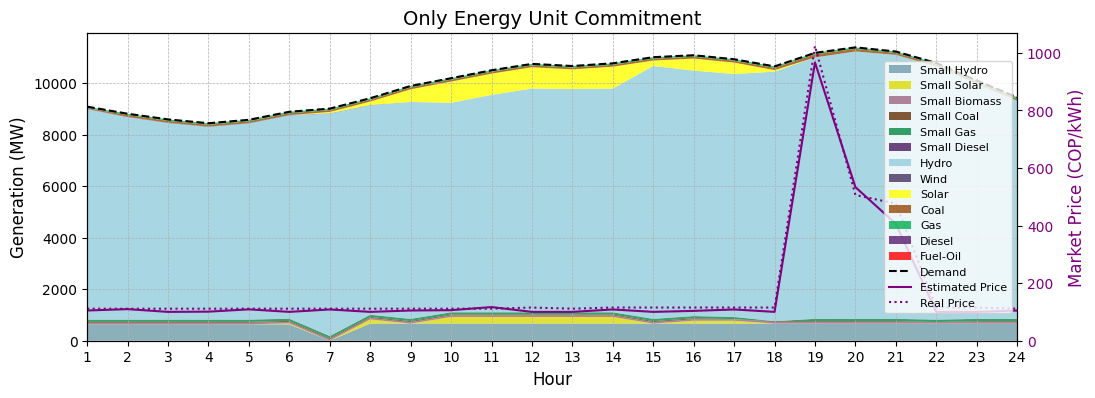

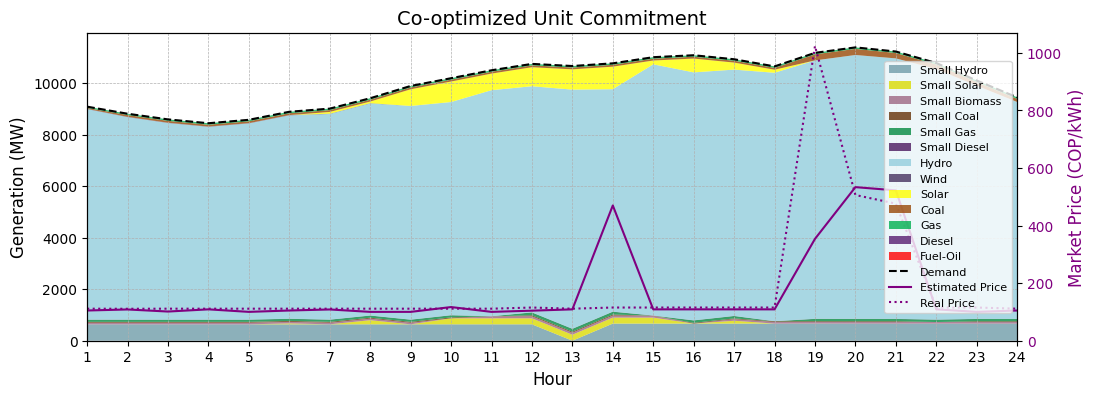

In [11]:
demand_df = ampl.get_data("demand").to_pandas()
real_spot_price = pd.DataFrame(
    dct_data["real_spot_price"], index=range(1, 25), columns=["real_spot_price"]
)
plot_dispatch(
    results_df,
    bids_file,
    demand_df,
    dual_df,
    real_spot_price,
    title="Only Energy Unit Commitment",
)
plot_dispatch(
    results_res_df,
    bids_file,
    demand_df,
    dual_res_df,
    real_spot_price,
    title="Co-optimized Unit Commitment",
)

### Total Cost Comparison

Co-optimizing reserve in the unit commitment clearly impacts the total operating cost of the system. In this case, the only energy UC (OE-UC) provided a total cost of **~25500 MCOP** (around **6.4 MUSD**), while optimizing the reserve yielded a total cost of **~26500 MCOP** (about **6.6 MUSD**). This difference of roughly **+0.2 MUSD** should not be interpreted as an increased total system operation cost. On the contrary, several studies have proven that this approach reduces this quantity. In order to make a complete analysis, exogenous reserve costs should be added to the OE-UC.

## 7. Analysis (Optimization Perspective)

Solving this MILP model using real data (although simplified) required several important insights about practical optimization and the energy sector.

### Solving Times and Strategies

The UC model is computationally intensive. Several strategies were employed to manage and reduce solution times:

1.  **MIP Gap (`mipgap`):** one of the most effective tools for reducing runtime is to relax the optimality requirement. The model was solved using a MIP gap of 0.1% (`mipgap=0.001`) from the theoretical optimum. It is important to note, however, that the validity of this change depends on the specific application and must be considered for each case. However, for most business decisions, this provides an excellent trade-off between solution speed and quality. In this particular case, solving times reduced from **`2.5 minutes` to `~13 seconds`** on an 8GB RAM + AMDRyzen 5 PRO processor pc.

2.  **Constraint Formulation:** Formulating the `DemandBalance` constraint with an inequality (`>=`) instead of a strict equality (`=`) significantly reduced solution time by to some of the solvers tested, without affecting the final outcome. This was specially notorious when working with the model with default mipgap option. Providing tighter variable limits and revising model's units (scaling) could also help ease the computational load.

3.  **Providing a Warm Start:** an additional performance booster, typically used in energy models, is to provide a "warm start" or an initial solution. This allows the solver to skip the often time-consuming process of finding a first good integer solution and focus directly on proving optimality, reducing runtime for complex, recurring problems. In this case, the LP relaxation of the original problem was used as warm_start.

4.  **Data Simplification:** A final strategy to optimizing model performance is to reduce the problem size by grouping similar units (e.g., all price-taker solar plants) into a single equivalent generator. This was implemented in the corresponding bid file: `bids_*_small.xlsx`. Non-grouped file `bids_*.xlsx` is also included for further tests.

5. **Keeping size to minimum:** model formulation is critical to obtaining good optimization performance. In the previous implementation of the model, some ramp and minimum time constraints were defined over all plants abusing of default parameters to avoid further specifying the sets. This caused the model to take considerably more time to get to the solution and yielded unexpected results (specially regarding the small grouped plants). The following sections define two addtional models where this is fixed, providing smooth curves and much faster solving times (*even allowing to use one order of magnitude smaller mip_gap, the complete dataset and a non-commercial solver*). It is worth mentioning that the presolve routines of some solvers may be further tuned to find and drop this redundant constraints.


In [12]:
%%writefile unit_commitment_detail.mod
# Model Name: Simplified Unit Commitment for Colombia
# Last Updated: 18 July 2025

### SETS
set PLANTS;                     # All the plants connected to the grid
set PLANTS_SUSD within PLANTS;  # All the plants requiring startup/shutdown costs
set PLANTS_RAMP within PLANTS;  # All the plants requiring ramps
set PLANTS_TIMES within PLANTS; # All the plants requiring min up/down times
set PERIODS = 1..24;            # Time periods for the model, e.g., hours in a day


### PARAMETERS
param demand {PERIODS} >= 0;                                        # Demand for each period
param max_output {PLANTS, PERIODS} >= 0;                            # Maximum capacity/availability of each plant in each period (MW)
param bid_price {PLANTS, PERIODS} >= 0 default 85;                  # Bid price of each plant in each period ($/kWh). Default value added for price-takers.
param deficit_cost {PERIODS} >= 0;                                  # Cost of unserved energy in each period ($/kWh)
param min_output {PLANTS, PERIODS} >= 0 default 0;                  # Minimum output of each plant if turned on.
param ramp_up {PLANTS_RAMP} >= 0 default 0;                              # Ramp-up rate of each plant (MW/hour)
param ramp_down {PLANTS_RAMP} >= 0 default 0;                            # Ramp-down rate of each plant (MW/hour)
param startup_cost {PLANTS_SUSD} >= 0 default 0;                         # Startup cost of each plant ($)
param shutdown_cost {PLANTS_SUSD} >= 0 default 0;                        # Shutdown cost of each plant ($)
param min_up_time {PLANTS_TIMES} integer >= 0 default 0;                  # Minimum number of periods a plant must remain on once started
param min_down_time {PLANTS_TIMES} integer >= 0 default 0;                # Minimum number of periods a plant must remain off once shut down
param initial_status {PLANTS} binary default 0;                     # Initial status of each plant (1 if on, 0 if off)
param initial_power {PLANTS} >= 0 default 0;                        # Initial power output of each plant (MW)
param initial_hours_on {PLANTS} integer >= 0 default 0;             # Initial hours each plant has been on
param initial_hours_off {PLANTS} integer >= 0 default 0;            # Initial hours each plant has been off


### VARIABLES
var Generation {PLANTS, PERIODS} >= 0;                      # Power generated by each plant in each period (MW)
var BinOn {PLANTS, PERIODS} binary;                         # 1 if plant is on in the period, 0 otherwise
var BinStartUp {PLANTS_SUSD union PLANTS_RAMP, PERIODS} binary;                    # 1 if plant starts up in the period, 0 otherwise
var BinShutDown {PLANTS_SUSD union PLANTS_RAMP, PERIODS} binary;                   # 1 if plant shuts down in the period, 0 otherwise
var Deficit {PERIODS} >= 0;                                 # Unserved energy in each period (MW)


### OBJECTIVE FUNCTION
minimize TotalCost:  # Measured in thousands of COP
    # Generation costs
    sum {p in PLANTS, t in PERIODS} (bid_price[p,t] * Generation[p,t]) +
    # Startup costs
    sum {p in PLANTS_SUSD, t in PERIODS} (startup_cost[p] * BinStartUp[p,t]) +
    # Shutdown costs
    sum {p in PLANTS_SUSD, t in PERIODS} (shutdown_cost[p] * BinShutDown[p,t]) +
    # Penalty for unserved energy
    sum {t in PERIODS} (deficit_cost[t] * Deficit[t]);


### CONSTRAINTS
# Demand Balance
subject to DemandBalance {t in PERIODS}:
    sum {p in PLANTS} Generation[p,t] + Deficit[t] = demand[t];

# Power output limits per plant
subject to PowerOutputLowerLimit {p in PLANTS, t in PERIODS}:
    min_output[p,t] * BinOn[p,t] <= Generation[p,t];

subject to PowerOutputUpperLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] <= max_output[p,t] * BinOn[p,t];

# Binding binaries behaviour
subject to StartUpShutDownLogic {p in PLANTS_SUSD, t in PERIODS}:
    BinOn[p,t] - (if t = 1 then initial_status[p] else BinOn[p,t-1]) = BinStartUp[p,t]  - BinShutDown[p,t];

subject to NoSimulatneousStartUpShutDown {p in PLANTS_SUSD, t in PERIODS}:
    BinStartUp[p,t] + BinShutDown[p,t] <= 1;

# Ramp-up and ramp-down constraints
subject to RampUpLimit {p in PLANTS_RAMP, t in PERIODS}:
    Generation[p,t] - (if t = 1 then initial_power[p] else Generation[p,t-1]) <=
    ramp_up[p] * (if t = 1 then initial_status[p] else BinOn[p,t-1]) + max_output[p,t] * BinStartUp[p,t];

subject to RampDownLimit {p in PLANTS_RAMP, t in PERIODS}:
    (if t = 1 then initial_power[p] else Generation[p,t-1]) - Generation[p,t] <=
    ramp_down[p] * BinOn[p,t] + (if t = 1 then initial_power[p] else max_output[p,t-1]) * BinShutDown[p,t];

# Minimum up time constraint (considering min_up_time greater than 24 hours)
subject to MinimumUpTime {p in PLANTS_TIMES, t in PERIODS}:
    sum {k in t .. min(t + min_up_time[p] - 1, 24)} BinOn[p,k] >= (min(t + min_up_time[p] - 1, 24) - t + 1) * BinStartUp[p,t];

# Minimum up time constraint (considering initial status)
subject to MinmumUpTimeInitiallyOn {p in PLANTS_TIMES: initial_status[p] = 1}:
    sum {t in 1 .. max(0,min(min_up_time[p]-initial_hours_on[p], 24))} BinOn[p,t] >= max(0,min(min_up_time[p]-initial_hours_on[p], 24));

# Minimum down time constraint (considering min_down_time greater than 24 hours)
subject to MinimumDownTime {p in PLANTS_TIMES, t in PERIODS}:
    sum {k in t .. min(t + min_down_time[p] - 1, 24)} (1 - BinOn[p,k]) >= (min(t + min_down_time[p] - 1, 24) - t + 1) * BinShutDown[p,t];

# Minimum down time constraint (considering initial status)
subject to MinimumDownTimeInitiallyOff {p in PLANTS_TIMES: initial_status[p] = 0}:
    sum {t in 1 .. max(0,min(min_down_time[p]-initial_hours_off[p], 24))} (1 - BinOn[p,t]) >= max(0,min(min_down_time[p]-initial_hours_off[p], 24));


Writing unit_commitment_detail.mod


In [13]:
%%writefile unit_commitment_reserve_detail.mod
# Model Name: Simplified Unit Commitment for Colombia, including Reserve
# Last Updated: 18 July 2025

### SETS
set PLANTS;                     # All the plants connected to the grid
set PLANTS_SUSD within PLANTS;  # All the plants requiring startup/shutdown costs
set PLANTS_RAMP within PLANTS;  # All the plants requiring ramps
set PLANTS_TIMES within PLANTS; # All the plants requiring min up/down times
set PERIODS = 1..24;            # Time periods for the model, e.g., hours in a day


### PARAMETERS
param demand {PERIODS} >= 0;                                        # Demand for each period
param max_output {PLANTS, PERIODS} >= 0;                            # Maximum capacity/availability of each plant in each period (MW)
param bid_price {PLANTS, PERIODS} >= 0 default 85;                   # Bid price of each plant in each period ($/kWh). Default value added for price-takers.
param deficit_cost {PERIODS} >= 0;                                  # Cost of unserved energy in each period ($/kWh)
param min_output {PLANTS, PERIODS} >= 0 default 0;                  # Minimum output of each plant if turned on.
param ramp_up {PLANTS_RAMP} >= 0 default 0;                              # Ramp-up rate of each plant (MW/hour)
param ramp_down {PLANTS_RAMP} >= 0 default 0;                            # Ramp-down rate of each plant (MW/hour)
param startup_cost {PLANTS_SUSD} >= 0 default 0;                         # Startup cost of each plant ($)
param shutdown_cost {PLANTS_SUSD} >= 0 default 0;                        # Shutdown cost of each plant ($)
param min_up_time {PLANTS_TIMES} integer >= 0 default 0;                  # Minimum number of periods a plant must remain on once started
param min_down_time {PLANTS_TIMES} integer >= 0 default 0;                # Minimum number of periods a plant must remain off once shut down
param initial_status {PLANTS} binary default 0;                     # Initial status of each plant (1 if on, 0 if off)
param initial_power {PLANTS} >= 0 default 0;                        # Initial power output of each plant (MW)
param initial_hours_on {PLANTS} integer >= 0 default 0;             # Initial hours each plant has been on
param initial_hours_off {PLANTS} integer >= 0 default 0;            # Initial hours each plant has been off
param reserve_up_requirement {PERIODS} >= 0 default 0;              # Upward reserve requirement for each period (MW)
param reserve_down_requirement {PERIODS} >= 0 default 0;            # Downward reserve requirement for each period (MW)
param max_reserve_up {PLANTS, PERIODS} >= 0 default 0;              # Maximum upward reserve capacity of each plant in each period (MW)
param max_reserve_down {PLANTS, PERIODS} >= 0 default 0;            # Maximum downward reserve capacity of each plant in each period (MW)
param reserve_up_bid_price {PLANTS, PERIODS} >= 0 default 0;        # Bid price for upward reserve of each plant in each period ($/kWh)
param reserve_down_bid_price {PLANTS, PERIODS} >= 0 default 0;      # Bid price for downward reserve of each plant in each period ($/kWh)


### VARIABLES
var Generation {PLANTS, PERIODS} >= 0;                      # Power generated by each plant in each period (MW)
var BinOn {PLANTS, PERIODS} binary;                         # 1 if plant is on in the period, 0 otherwise
var BinStartUp {PLANTS_SUSD union PLANTS_RAMP, PERIODS} binary;                    # 1 if plant starts up in the period, 0 otherwise
var BinShutDown {PLANTS_SUSD union PLANTS_RAMP, PERIODS} binary;                   # 1 if plant shuts down in the period, 0 otherwise
var Deficit {PERIODS} >= 0;                                 # Unserved energy in each period (MW)
var ReserveUp {PLANTS, PERIODS} >= 0;                       # Upward reserve provided by each plant in each period (MW)
var ReserveDown {PLANTS, PERIODS} >= 0;                     # Downward reserve provided by each plant in each period (MW)


### OBJECTIVE FUNCTION
minimize TotalCost:  # Measured in thousands of COP
    # Generation costs
    sum {p in PLANTS, t in PERIODS} (bid_price[p,t] * Generation[p,t]) +
    # Startup costs
    sum {p in PLANTS_SUSD, t in PERIODS} (startup_cost[p] * BinStartUp[p,t]) +
    # Shutdown costs
    sum {p in PLANTS_SUSD, t in PERIODS} (shutdown_cost[p] * BinShutDown[p,t]) +
    # Penalty for unserved energy
    sum {t in PERIODS} (deficit_cost[t] * Deficit[t]) +
    # Upward reserve costs
    sum {p in PLANTS, t in PERIODS} (reserve_up_bid_price[p,t] * ReserveUp[p,t]) +
    # Downward reserve costs
    sum {p in PLANTS, t in PERIODS} (reserve_down_bid_price[p,t] * ReserveDown[p,t]);


### CONSTRAINTS
# Demand Balance
subject to DemandBalance {t in PERIODS}:
    sum {p in PLANTS} Generation[p,t] + Deficit[t] = demand[t];

# Reserve Balance
subject to ReserveUpBalance {t in PERIODS}:
    sum {p in PLANTS} ReserveUp[p,t] >= reserve_up_requirement[t];

subject to ReserveDownBalance {t in PERIODS}:
    sum {p in PLANTS} ReserveDown[p,t] >= reserve_down_requirement[t];

# Power output limits per plant
subject to PowerOutputLowerLimit {p in PLANTS, t in PERIODS}:
    min_output[p,t] * BinOn[p,t] <= Generation[p,t] - ReserveDown[p,t];

subject to PowerOutputUpperLimit {p in PLANTS, t in PERIODS}:
    Generation[p,t] + ReserveUp[p,t] <= max_output[p,t] * BinOn[p,t];

# Reserve limits per plant
subject to ReserveUpLimit {p in PLANTS, t in PERIODS}:
    ReserveUp[p,t] <= max_reserve_up[p,t];

subject to ReserveDownLimit {p in PLANTS, t in PERIODS}:
    ReserveDown[p,t] <= max_reserve_down[p,t];

# Binding binaries behaviour
subject to StartUpShutDownLogic {p in PLANTS_SUSD, t in PERIODS}:
    BinStartUp[p,t]  - BinShutDown[p,t] = BinOn[p,t] - (if t = 1 then initial_status[p] else BinOn[p,t-1]);

subject to NoSimulatneousStartUpShutDown {p in PLANTS_SUSD, t in PERIODS}:
    BinStartUp[p,t] + BinShutDown[p,t] <= 1;

# Ramp-up and ramp-down constraints
subject to RampUpLimit {p in PLANTS_RAMP, t in PERIODS}:
    Generation[p,t] - (if t = 1 then initial_power[p] else Generation[p,t-1]) <=
    ramp_up[p] * (if t = 1 then initial_status[p] else BinOn[p,t-1]) + max_output[p,t] * BinStartUp[p,t];

subject to RampDownLimit {p in PLANTS_RAMP, t in PERIODS}:
    (if t = 1 then initial_power[p] else Generation[p,t-1]) - Generation[p,t] <=
    ramp_down[p] * BinOn[p,t] + (if t = 1 then initial_power[p] else max_output[p,t-1]) * BinShutDown[p,t];

# Minimum up time constraint (considering min_up_time greater than 24 hours)
subject to MinimumUpTime {p in PLANTS_TIMES, t in PERIODS}:
    sum {k in t .. min(t + min_up_time[p] - 1, 24)} BinOn[p,k] >= (min(t + min_up_time[p] - 1, 24) - t + 1) * BinStartUp[p,t];

# Minimum up time constraint (considering initial status)
subject to MinmumUpTimeInitiallyOn {p in PLANTS_TIMES: initial_status[p] = 1}:
    sum {t in 1 .. max(0,min(min_up_time[p]-initial_hours_on[p], 24))} BinOn[p,t] >= max(0,min(min_up_time[p]-initial_hours_on[p], 24));

# Minimum down time constraint (considering min_down_time greater than 24 hours)
subject to MinimumDownTime {p in PLANTS_TIMES, t in PERIODS}:
    sum {k in t .. min(t + min_down_time[p] - 1, 24)} (1 - BinOn[p,k]) >= (min(t + min_down_time[p] - 1, 24) - t + 1) * BinShutDown[p,t];

# Minimum down time constraint (considering initial status)
subject to MinimumDownTimeInitiallyOff {p in PLANTS_TIMES: initial_status[p] = 0}:
    sum {t in 1 .. max(0,min(min_down_time[p]-initial_hours_off[p], 24))} (1 - BinOn[p,t]) >= max(0,min(min_down_time[p]-initial_hours_off[p], 24));

Writing unit_commitment_reserve_detail.mod


In [14]:
# Model Size Reduction
ampl.reset()
ampl.read(energy_mod_file)
add_data_to_ampl(ampl, bids_file, dct_other=dct_data, reserve=False, detail=False)
ptype, nvars, ncons = describe_ampl_model(ampl, verbose=False)
print(
    f"Original Only Energy UC: {ptype} with {nvars} variables and {ncons} constraints."
)

ampl.reset()
ampl.read("unit_commitment_detail.mod")
add_data_to_ampl(ampl, bids_file, dct_other=dct_data, reserve=False, detail=True)
ptype, nvars, ncons = describe_ampl_model(ampl, verbose=False)
print(
    f"Modified Only Energy UC: {ptype} with {nvars} variables and {ncons} constraints."
)

ampl.reset()
ampl.read(reserve_mod_file)
add_data_to_ampl(ampl, bids_file, dct_other=dct_data, reserve=True, detail=False)
ptype, nvars, ncons = describe_ampl_model(ampl, verbose=False)
print(
    f"Original Energy+Reserve UC: {ptype} with {nvars} variables and {ncons} constraints."
)

ampl.reset()
ampl.read("unit_commitment_reserve_detail.mod")
add_data_to_ampl(ampl, bids_file, dct_other=dct_data, reserve=True, detail=True)
ptype, nvars, ncons = describe_ampl_model(ampl, verbose=False)
print(
    f"Modified Energy+Reserve UC: {ptype} with {nvars} variables and {ncons} constraints."
)

Original Only Energy UC:  (1) MILP (Mixed-Integer Linear Programming) with 8184 variables and 16429 constraints.
Modified Only Energy UC:  (1) MILP (Mixed-Integer Linear Programming) with 6024 variables and 9710 constraints.
Original Energy+Reserve UC:  (1) MILP (Mixed-Integer Linear Programming) with 12264 variables and 20557 constraints.
Modified Energy+Reserve UC:  (1) MILP (Mixed-Integer Linear Programming) with 10104 variables and 13838 constraints.


In [15]:
# Much faster and more precise than before
solve_model(
    ampl,
    mod_file="unit_commitment_detail.mod",
    bids_file="bids_20250513.xlsx",
    dct_data=dct_data,
    reserve=False,
    solver="highs",
    warm_lp=True,
    detail=True,
    mp_options="mipgap=0.0001",
)

results_df, dual_df = process_results(ampl, solver="gurobi", verbose=False)

HiGHS 1.11.0:   mip:gap = 0.0001
HiGHS 1.11.0: optimal solution; objective 25326679.69
921 simplex iterations
0 barrier iterations
HiGHS 1.11.0:   mip:gap = 0.0001
HiGHS 1.11.0: optimal solution; objective 25326679.69
829 simplex iterations
1 branching nodes

"option rel_boundtol 4.444424691474932e-06;"
will change deduced dual values.

Total demand supply cost: 25326679.68518981
Total deficit: Deficit    0
dtype: int64
Fixing integers to obtain shadow prices.
Total demand supply cost (relaxed LP): 25326679.6851898


In [16]:
# Much faster and more precise than before
solve_model(
    ampl,
    mod_file="unit_commitment_reserve_detail.mod",
    bids_file="bids_20250513.xlsx",
    dct_data=dct_data,
    reserve=True,
    solver="highs",
    warm_lp=True,
    detail=True,
    mp_options="mipgap=0.0001",
)

results_res_df, dual_res_df = process_results(ampl, solver="gurobi", verbose=False)

HiGHS 1.11.0:   mip:gap = 0.0001
HiGHS 1.11.0: optimal solution; objective 26328362.64
1019 simplex iterations
0 barrier iterations
HiGHS 1.11.0:   mip:gap = 0.0001
HiGHS 1.11.0: optimal solution; objective 26331094.48
2309 simplex iterations
1 branching nodes
absmipgap=2434.64, relmipgap=9.24626e-05

"option rel_boundtol 4.444424691474932e-06;"
will change deduced dual values.

Total demand supply cost: 26331094.476067208
Total deficit: Deficit    0
dtype: int64
Fixing integers to obtain shadow prices.
Total demand supply cost (relaxed LP): 26331094.476067137


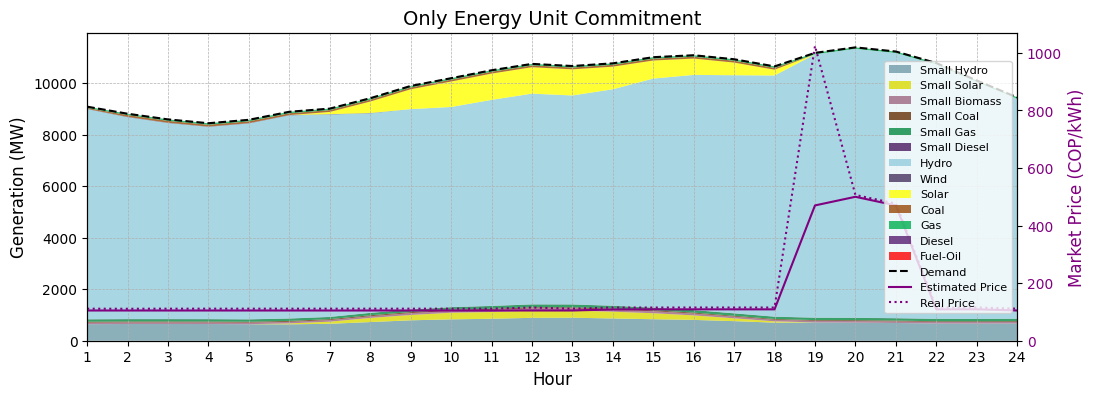

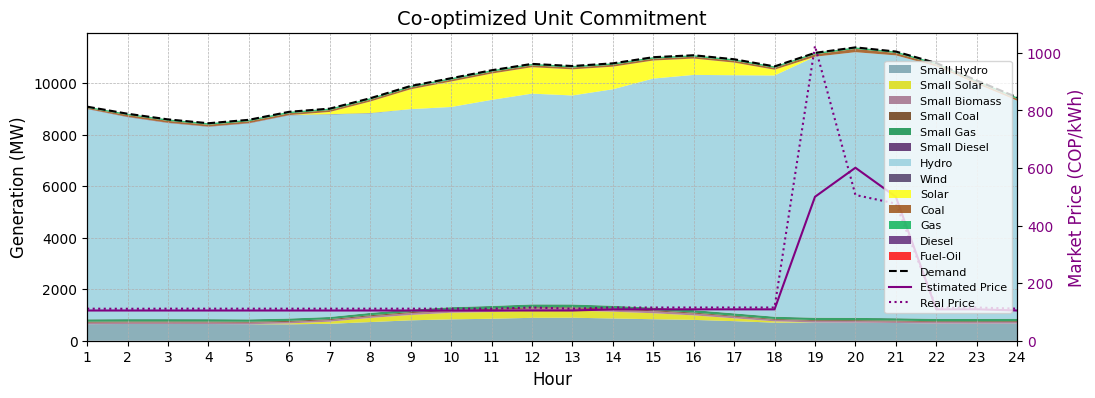

In [17]:
demand_df = ampl.get_data("demand").to_pandas()
real_spot_price = pd.DataFrame(
    dct_data["real_spot_price"], index=range(1, 25), columns=["real_spot_price"]
)
plot_dispatch(
    results_df,
    "bids_20250513.xlsx",
    demand_df,
    dual_df,
    real_spot_price,
    title="Only Energy Unit Commitment",
)
plot_dispatch(
    results_res_df,
    "bids_20250513.xlsx",
    demand_df,
    dual_res_df,
    real_spot_price,
    title="Co-optimized Unit Commitment",
)

### Estimating System Prices

Obtaining accurate system prices from the UC-MILP is not a trivial task.

1.  **Initial Approach (Dual Variables):** For continuous convex LPs, the dual variable of the demand balance constraint directly provides the system marginal price. However, duals for MILPs are not as clearly defined. One approach is to use the duals of the final LP relaxation, which may not reveal useful information about the original problem. This is caused by the behaviour of integer variables, that change in discrete steps.

2.  **Challenge (Infeasible Relaxed Problem):** A "fix-and-resolve" strategy (fixing binaries and re-solving the LP) was attempted to get duals values. This initially failed with some solvers due to floating-point errors from the MIP solve (`1.00000000001`) that made the LP mathematically infeasible when the binary variables were fixed.

3.  **Solution (Robust Duals):** The numerical infeasibility was solved by **rounding** the binary variables to perfect integers (0 or 1) before fixing them using the `fix_binary_vars()` function. Adjusting a tolerance option may have reached a similar result. This "cleaned" the data and made the subsequent LP solve feasible, providing a set of dual values for the final graph, although representing just an initial approximation and not necessarily the real system price.

4.  **Alternative Solution (Sensitivity Analysis):** Another possible method to obtain the system price is to perform a sensitivity analysis on the demand parameter. Thus, changing its value and observing the consequent change of the objective (`TotalCost`). Nevertheless, the precision of the solution may greatly affect results obtained trough this method. Refining porblem's units and mipgap may aid in the analysis, although damaging the model performance.

4.  **Alternative Solution (Primal Price Market Estimation):** A final solution to obtaining the system price is to follow some heuristic or market rule approach given the final result obtained from the MILP. The price for each hour can be determined by the bid price of the most expensive generator that is online and has available headroom to increase generation. Some care may have to be taken with respect of plants with forced generation (minimum up-time, ramps, etc.) or reserve allocation.